In [1]:
import pandas as pd
import numpy as np
import scipy.signal as ss
import math
import datetime
import pickle
import random
import copy
from dtw import dtw
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load screeningList and matchedMovies
screeningList = pickle.load(open("screeningList.p",'rb'))
matchedMovies = pickle.load(open("matchedMovies.p",'rb'))

## Dynamic Time Warping (DTW)

### Helper Functions

In [5]:
def preliminaryAlignment(runtime, vocTime, vocTimeList,preliminaryAlignmentTolerance,co2Df):
    effectiveRuntime = (runtime + preliminaryAlignmentTolerance) * 2 #tolerance added is 15mins and then multiplied by 2 to get the number of 30s intervals
    vocIndex = vocTimeList.index(vocTime)
    vocEndIndex = vocIndex + effectiveRuntime
    vocWindow = co2Df.loc[vocIndex:vocEndIndex][:]
    return vocWindow

In [6]:
def calculateDeltaBetweenPeaks(vocWindow):

    #find peaks 
    peakList = list()
    normalisedPeakList = list()
    #find_peaks returns the index values of the peaks within the VOC frame 
    peaks = ss.find_peaks(vocWindow[:]['CO2'].values)
    
    #Using the index values find the actual values of the peaks 
    deltaList = list()
    if len(peaks[0]) != 0:
        for peakIndex in peaks[0]:
            peakList.append(vocWindow[:]['CO2'].values[peakIndex])

        #normalise the peaks (divide by highest VOC value)
        maxPeak = max(peakList)
        for peakValue in peakList:
            normalisedPeakList.append(peakValue/maxPeak) 

        #calculate the gradient and distance between peaks
        #the gradientList and distanceList for vocFrame
        
        for peakIndex in range(1, len(normalisedPeakList)):
            prevPeak = normalisedPeakList[peakIndex-1]
            currPeak = normalisedPeakList[peakIndex]
            delta = currPeak - prevPeak
            deltaList.append(delta)
 
    return deltaList, peakList


In [7]:
def gradientAlignment(vocWindow,gradThreshold, effectiveRuntime,vocTime,movieMatched):

    vocList = list()
    
    deltaList, peakList = calculateDeltaBetweenPeaks(vocWindow)

    if len(deltaList) != 0:

        #apply constraints to trim the voc window
        frontIndex = round(len(deltaList)*0.8) #only check the last 20% of the voc window
        vocConstraintWindow = deltaList[frontIndex:]

        if min(vocConstraintWindow) > gradThreshold:

            #if the min gradient in the frame is larger than the threshold then just cut off the last peak
            lastPeakIndex = list(vocWindow[:]['CO2'].values).index(peakList[-1])
            firstIndex = lastPeakIndex - effectiveRuntime 
            vocWindow = vocWindow[firstIndex:lastPeakIndex][:]
            vocList.append(vocWindow)
            
        else: 

            #if min gradient in frame is less than threshold then cut off the peak that starts that gradient
            #find the first grad that is lower than the threshold

            for grad in vocConstraintWindow:
                if grad < gradThreshold:
                    gradIndex = deltaList.index(grad)
                    associatedPeak = peakList[gradIndex]
                    endIndex = list(vocWindow[:]['CO2'].values).index(associatedPeak)

                    firstIndex = endIndex - effectiveRuntime

                    if firstIndex > 0: #positive index
                        vocWindow = vocWindow[firstIndex:endIndex][:]
                        vocList.append(vocWindow)
                        break

    return vocList


In [8]:
def dataAlignment(scheduledTimeList, movieScreeningList, movieList, filledPercentageList, vocTimeList, matchedMovieList, timeList, vocScreenings, co2Df, preliminaryAlignmentTolerance, gradThreshold, filledPercentageConstraint,movieRuntimeDf, originalVOCFrames):
   
    for vocTime in vocTimeList: 
    #match timing with movie scheduled timing 
        try:
            timeIndex = scheduledTimeList.index(vocTime)
        except:
            continue 
            
        if vocTime not in timeList:
            if filledPercentageList[timeIndex] > filledPercentageConstraint: #only use well filled movies
                try:
                    movieMatched = movieScreeningList[timeIndex]    
                    movieIndex = movieList.index(movieMatched)      
                except:
                    continue 
                    
                effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
                runtime = movieRuntimeDf.loc[movieIndex]['runtime (mins)']
                vocWindow = preliminaryAlignment(runtime, vocTime, vocTimeList, preliminaryAlignmentTolerance, co2Df)
                vocList = gradientAlignment(vocWindow,gradThreshold, effectiveRuntime,vocTime,movieMatched)
                if len(vocList) > 0:
                    originalVOCFrames.append(vocWindow)
                    timeList.append(vocTime)
                    matchedMovieList.append(movieMatched)
                    vocScreenings = vocScreenings + vocList
                
    
    return vocScreenings, matchedMovieList, timeList, originalVOCFrames


In [9]:
def normalisation(vocScreenings):
    
    #use minMaxScaler to scale the screenings between 0 and 1 
    
    scaledScreenings = list()
    for index in range(0, len(vocScreenings)):

        screening = vocScreenings[index]

        #scale screening
        screening = screening['CO2'].values.reshape(-1,1)
        scaler = MinMaxScaler()
        scaledScreening = scaler.fit_transform(screening).ravel()
        scaledScreenings.append(scaledScreening)
        
    return scaledScreenings

In [10]:
def errorAdjustment(vocList, timeList, matchedMovieList,originalVOCFrames,movieRuntimeDf):
    #VOC Screenings to be manually editted to after inspection

    #The Hunger Games: Catching Fire 27-12-2013 13:15
    #Buddy 29-12-2013 19:30
    #Walter Mitty 02-01-2014 17:15
    #The Hunger Games: Catching Fire 05-01-2014 13:45
    #Walter Mitty 05-01-2014 17:15
    #The Hunger Games: Catching Fire 07-01-2014 13:45
    #Paranormal Activity 09-01-2014 20:35
    #Hobbit 2 10-01-2014 16:30
    #Paranormal Activity 10-01-2014 22:35
    #Help I Shrunk 27-12-2015 11:30
    #Help I Shrunk 30-12-2015 11:30
    #Help I Shrunk 02-01-2016 11:30
    # Help I Shrunk 03-01-2016 11:30
    #I'm Off Then 27-12-2015 20:00
    #I'm Off Then 30-12-2015 20:00
    #I'm Off Then 31-12-2015 20:00
    #I'm Off Then 02-01-2016 17:30
    #I'm Off Then 02-01-2016 20:00
    #I'm Off Then 03-01-2016 17:30
    #Star Wars-A Force Awakens 22-12-2015 22:30
    #Star Wars-A Force Awakens 28-12-2015 22:30
    #Star Wars-A Force Awakens 29-12-2015 22:30

    errorList = ['27-12-2013 13:15', '29-12-2013 19:30', '02-01-2014 17:15', '05-01-2014 13:45',
                '05-01-2014 17:15', '07-01-2014 13:45', '09-01-2014 20:35', '10-01-2014 16:30', 
                '10-01-2014 22:35', '22-12-2015 22:30', '28-12-2015 22:30', '29-12-2015 22:30', 
                '27-12-2015 20:00', '30-12-2015 20:00', '31-12-2015 20:00', '02-01-2016 17:30',
                '02-01-2016 20:00','03-01-2016 17:30', '30-12-2015 11:30', 
                '02-01-2016 11:30', '03-01-2016 11:30']
                
    adjustedVOCList = copy.deepcopy(vocList)

    movieList = list(movieRuntimeDf['movie'])

    for errorDate in errorList:
        
        errorIndex = timeList.index(errorDate)
        matchedMovie = matchedMovieList[errorIndex]
        movieIndex = movieList.index(matchedMovie)
        vocFrame = originalVOCFrames[errorIndex]
   
        #Star Wars
        if errorDate == '22-12-2015 22:30':
            endOfMovie = '23-12-2015 00:55'
            movieIndex = movieList.index('Star Wars-The Force Awakens')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow
        elif errorDate == '28-12-2015 22:30':
            endOfMovie = '29-12-2015 00:59'
            movieIndex = movieList.index('Star Wars-The Force Awakens')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow
        elif errorDate == '29-12-2015 22:30':
            endOfMovie = '30-12-2015 01:15'
            movieIndex = movieList.index('Star Wars-The Force Awakens')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow

        #2013 movies
        elif errorDate == '27-12-2013 13:15':
            endOfMovie = '27-12-2013 15:59' 
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow
        elif errorDate == '29-12-2013 19:30':
            endOfMovie = '29-12-2013 21:28' 
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow  
        elif errorDate == '02-01-2014 17:15':
            endOfMovie = '02-01-2014 19:21' 
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow  
        elif errorDate == '05-01-2014 13:45':
            endOfMovie = '05-01-2014 16:21' 
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow        
        elif errorDate == '05-01-2014 17:15':
            endOfMovie = '05-01-2014 19:21' 
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow  
        elif errorDate == '07-01-2014 13:45':
            endOfMovie = '07-01-2014 16:10' 
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime 
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow              
        elif errorDate == '09-01-2014 20:35':
            endOfMovie = '09-01-2014 22:28'
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow  
        elif errorDate == '10-01-2014 16:30':
            endOfMovie = '10-01-2014 19:50'
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow              
        elif errorDate == '10-01-2014 22:35':
            endOfMovie = '11-01-2014 00:25'
            movieIndex = movieList.index(matchedMovie)
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow  

        #I'm Off Then
        elif errorDate == '27-12-2015 20:00':
            endOfMovie = '27-12-2015 21:54'
            movieIndex = movieList.index('I\'m Off Then')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow            
        elif errorDate == '30-12-2015 20:00':
            endOfMovie = '30-12-2015 21:52'
            movieIndex = movieList.index('I\'m Off Then')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow            
        elif errorDate == '31-12-2015 20:00':
            endOfMovie = '31-12-2015 21:53'
            movieIndex = movieList.index('I\'m Off Then')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow            
        elif errorDate == '02-01-2016 17:30':
            endOfMovie = '02-01-2016 19:22'
            movieIndex = movieList.index('I\'m Off Then')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow  
        elif errorDate == '02-01-2016 20:00':
            endOfMovie = '02-01-2016 21:53'
            movieIndex = movieList.index('I\'m Off Then')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow
        elif errorDate == '03-01-2016 17:30':
            endOfMovie = '03-01-2016 19:17'
            movieIndex = movieList.index('I\'m Off Then')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow
        
        #Help I shrunk the teacher   
        elif errorDate == '30-12-2015 11:30':
            endOfMovie = '30-12-2015 13:26'
            movieIndex = movieList.index('Help, I Shrunk My Teacher')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow
        elif errorDate == '02-01-2016 11:30':
            endOfMovie = '02-01-2016 13:23'
            movieIndex = movieList.index('Help, I Shrunk My Teacher')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime + 1
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow           
        elif errorDate == '03-01-2016 11:30':
            endOfMovie = '03-01-2016 13:23'
            movieIndex = movieList.index('Help, I Shrunk My Teacher')
            effectiveRuntime = movieRuntimeDf.loc[movieIndex]['effective runtime']
            vocEndIndex = list(vocFrame[:]['Time'].values).index(endOfMovie)
            vocStartIndex = vocEndIndex - effectiveRuntime
            vocWindow = vocFrame[vocStartIndex:vocEndIndex][:]
            adjustedVOCList[errorIndex] = vocWindow

    return adjustedVOCList

In [11]:
#data alignment, scaling and error adjustment 
def dataPipeline(voc):
    
    #user macros
    gradThreshold = -0.045
    preliminaryAlignmentTolerance = 50
    filledPercentageConstraint = 10 #movie must have atleast 10% filled to get a decent reading

    #read in the various csvs
    #2013 Dataset
    vocPath = 'Numerical Data/2013VOCData.csv'
    voc2013Df = pd.read_csv(vocPath, usecols = ['Time',voc], header = 0, nrows = 74208)
    movieScreeningsPath = 'Numerical Data/screening_times.csv'
    movingScreeningsDf = pd.read_csv(movieScreeningsPath, usecols = ['scheduled','movie','filled %'])
    movieRuntimesPath = 'Numerical Data/movie_runtimes.csv'
    movieRuntimeDf = pd.read_csv(movieRuntimesPath, usecols = ['movie', 'runtime (mins)', 'effective runtime'])
    #2015 Dataset
    starWarsPath = 'Numerical Data/Star Wars-The Force Awakens.csv'
    starWarsScreeningDf = pd.read_csv(starWarsPath)
    imOffThenPath = 'Numerical Data/I\'m Off Then.csv'
    imOffThenScreeningDf = pd.read_csv(imOffThenPath)
    helpIShrunkTheTeacherPath = 'Numerical Data/Help, I Shrunk My Teacher.csv'
    helpIShrunkTheTeacherScreeningDf = pd.read_csv(helpIShrunkTheTeacherPath)
    vocPath = 'Numerical Data/2015VOCData.csv'
    voc2015Df = pd.read_csv(vocPath, usecols = ['Time', voc])

    #Standardize times within the VOC dataset
    #VOC timings with datetime object
    for i in range(0,voc2013Df.shape[0]):
        vocTime = voc2013Df.loc[i]['Time']
        vocTime = vocTime[1:len(vocTime)-1]
        date = datetime.datetime.strptime(vocTime, "%m/%d/%Y %H:%M:%S")
        voc2013Df.at[i,'Time'] = date.strftime('%d-%m-%Y %H:%M')
    for i in range(0, voc2015Df.shape[0]):
        vocTime = voc2015Df.loc[i]['Time']
        date = datetime.datetime.strptime(vocTime, "%d/%m/%Y %H:%M")
        voc2015Df.at[i,'Time'] = date.strftime('%d-%m-%Y %H:%M')

    #Standardize times within the cinema movie schedule
    #2013
    for i in range(0,movingScreeningsDf.shape[0]):
        scheduledTime = movingScreeningsDf.loc[i]['scheduled']
        scheduledTimeObj = datetime.datetime.strptime(scheduledTime, "%d/%m/%Y %H:%M")
        scheduledTime = scheduledTimeObj.strftime('%d-%m-%Y %H:%M')
        movingScreeningsDf.at[i,'scheduled'] = scheduledTime
    #2015 Star Wars
    for i in range(0, starWarsScreeningDf.shape[0]):
        beginTime = starWarsScreeningDf.loc[i]['Start']
        beginTimeObj = datetime.datetime.strptime(beginTime,  "%d/%m/%Y %H:%M")
        beginTime = beginTimeObj.strftime('%d-%m-%Y %H:%M')
        starWarsScreeningDf.at[i,'Start'] = beginTime
    #2015 I'm Off Then
    for i in range(0, imOffThenScreeningDf.shape[0]):
        beginTime = imOffThenScreeningDf.loc[i]['Start']
        beginTimeObj = datetime.datetime.strptime(beginTime,  "%d/%m/%Y %H:%M")
        beginTime = beginTimeObj.strftime('%d-%m-%Y %H:%M')
        imOffThenScreeningDf.at[i,'Start'] = beginTime    
    #2015 Help, I Shrunk The Teacher
    for i in range(0, helpIShrunkTheTeacherScreeningDf.shape[0]):
        beginTime = helpIShrunkTheTeacherScreeningDf.loc[i]['Start']
        beginTimeObj = datetime.datetime.strptime(beginTime,  "%d/%m/%Y %H:%M")
        beginTime = beginTimeObj.strftime('%d-%m-%Y %H:%M')
        helpIShrunkTheTeacherScreeningDf.at[i,'Start'] = beginTime

    #Data Alignment 
    #2013 Alignment
    scheduledTimeList = list(movingScreeningsDf.loc[:]['scheduled'])
    movieScreeningList = list(movingScreeningsDf.loc[:]['movie'])
    movieList = list(movieRuntimeDf.loc[:]['movie'])
    filledPercentageList = list(movingScreeningsDf.loc[:]['filled %'])
    vocTimeList = list(voc2013Df.loc[:]['Time'])

    matchedMovieList = list()
    timeList = list() 
    vocScreenings = list()
    originalVOCFrames = list()
    vocScreenings, matchedMovieList, timeList, originalVOCFrames = dataAlignment(scheduledTimeList, movieScreeningList, movieList, filledPercentageList, vocTimeList, matchedMovieList, timeList, vocScreenings, voc2013Df, preliminaryAlignmentTolerance, gradThreshold,filledPercentageConstraint,movieRuntimeDf,originalVOCFrames)

    #2015 Star Wars
    scheduledTimeList = list(starWarsScreeningDf.loc[:]['Start'])
    vocTimeList = list(voc2015Df.loc[:]['Time'])
    filledPercentageList = list(starWarsScreeningDf.loc[:]['filled %'])
    movieScreeningList = list(starWarsScreeningDf.loc[:]['Film'])
    vocScreenings, matchedMovieList, timeList, originalVOCFrames = dataAlignment(scheduledTimeList, movieScreeningList, movieList, filledPercentageList, vocTimeList, matchedMovieList, timeList, vocScreenings, voc2015Df, preliminaryAlignmentTolerance, gradThreshold,filledPercentageConstraint,movieRuntimeDf,originalVOCFrames)

    #2015 I'm Off Then
    scheduledTimeList = list(imOffThenScreeningDf.loc[:]['Start'])
    filledPercentageList = list(imOffThenScreeningDf.loc[:]['filled %'])
    movieScreeningList = list(imOffThenScreeningDf.loc[:]['Film'])   
    vocScreenings, matchedMovieList, timeList, originalVOCFrames = dataAlignment(scheduledTimeList, movieScreeningList, movieList, filledPercentageList, vocTimeList, matchedMovieList, timeList, vocScreenings, voc2015Df, preliminaryAlignmentTolerance, gradThreshold,filledPercentageConstraint,movieRuntimeDf,originalVOCFrames)

    #2015 Help, I Shrunk the Teacher
    scheduledTimeList = list(helpIShrunkTheTeacherScreeningDf.loc[:]['Start'])
    filledPercentageList = list(helpIShrunkTheTeacherScreeningDf.loc[:]['filled %'])
    movieScreeningList = list(helpIShrunkTheTeacherScreeningDf.loc[:]['Film'])     
    vocScreenings, matchedMovieList, timeList, originalVOCFrames = dataAlignment(scheduledTimeList, movieScreeningList, 
                                                                                 movieList, filledPercentageList, 
                                                                                 vocTimeList, matchedMovieList, timeList, 
                                                                                 vocScreenings, voc2015Df, 
                                                                                 preliminaryAlignmentTolerance, 
                                                                                 gradThreshold,filledPercentageConstraint,
                                                                                 movieRuntimeDf,originalVOCFrames)
    
    
    #error adjustment
    adjustedScreenings = errorAdjustment(vocScreenings, timeList, matchedMovieList,originalVOCFrames,movieRuntimeDf)

    #normalised vocs
    normalisedScreenings =  normalisation(adjustedScreenings)
    
    #save the normalised vocs
    #compile the matchedMovie, timeList and the screenings into a dictionary
    screeningDict = {'screenings':normalisedScreenings, #screenings of various movies
                     'matchedMovies':matchedMovieList, #corresponding movies 
                     'timeList': timeList #corresponding start times of the movie screenings
        
    }
    
    return screeningDict

### Main Code

In [16]:
#run data alignment, scaling and error adjustment 
screeningDict = dataPipeline('CO2')
#extract relevant information
vocScreenings = screeningDict['screenings']
movies = screeningDict['matchedMovies']

In [30]:
#extract specific movies and create a dictionary 
screeningsMovieDict = dict() #key is the movie and value is the list of screenings corresponding to that movie
movieList = np.unique(movies)
for movie in movieList:
    moviesOfAParticularScreening = list()
    #find where the movie is located in the matchedMovieList
    indices = np.where(np.array(movies)==movie)[0]
    #extract movie screenings
    movieScreenings = [vocScreenings[index] for index in indices]
    #add to dict
    screeningsMovieDict[movie] = movieScreenings

### Pick reference screenings 
<ul>
    <li> Hobbit 2: Screening  5</li>
    <li> Buddy: Screenng 1 </li>
    <li> Machete Kills: Screening 0 </li>
    <li> Walter Mitty: Screening 7 </li>
    <li> Paranormal Activity: Screening 0 </li>
    <li> The Hunger Games-Catching Fire: Screening 9 </li>
    <li> Help, I Shrunk My Teacher: Screening 4 </li>
    <li> I'm Off Then: Screening 6 </li>
    <li> Star Wars-The Force Awakens: Screening 19</li>
    <li> Suck Me Shakespeer: Screening 0 </li>
    <li> Walking with Dinosaurs: Screening 5</li>
    
</ul>

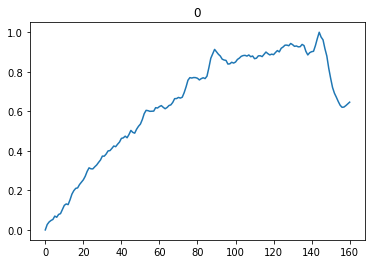

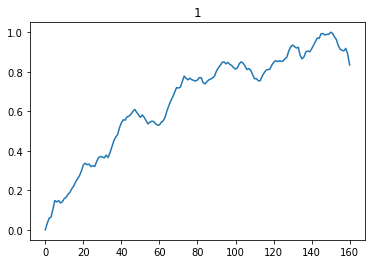

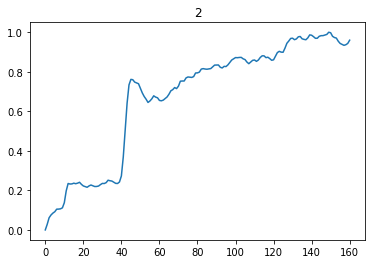

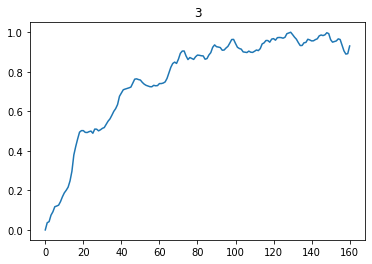

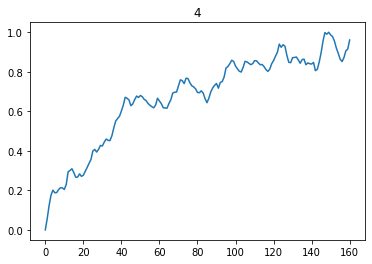

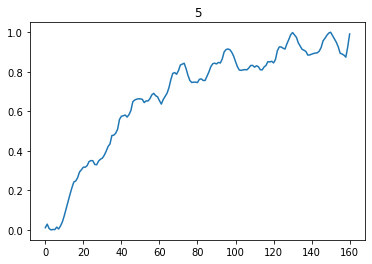

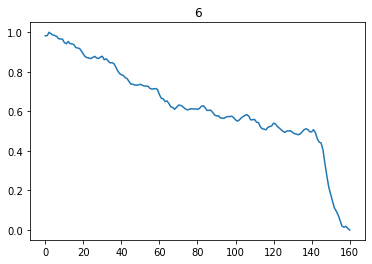

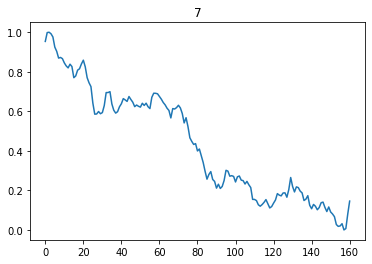

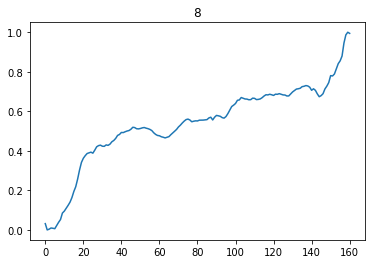

In [103]:
movieScreenings = screeningsMovieDict['Walking with Dinosaurs']
for index in range(0,len(movieScreenings)):
    
    screening = movieScreenings[index]
    
    plt.figure()
    plt.plot(screening)
    plt.title(index)


In [104]:
#indices of the reference screenings
referenceScreeningIndices = {'Hobbit 2':4,
                            'Buddy':1,
                            'Machete Kills':0,
                            'Walter Mitty':7,
                            'Paranormal Activity':0,
                            'The Hunger Games-Catching Fire':9,
                            'Help, I Shrunk My Teacher':4,
                            'I\'m Off Then':6,
                            'Star Wars-The Force Awakens':19,
                            'Suck Me Shakespeer':0,
                             'Walking with Dinosaurs': 5
                            }

In [107]:
#perform dtw
euclideanNorm = lambda screening1, screening2: np.abs(screening1 - screening2)

warpedMovieDict = dict() #contains both the warped screenings and the path information

for movie in movieList:
    
    warpedScreenings = list()
    pathList = list()
    
    #find the reference index of movie to access reference movie
    referenceScreeningIndex = referenceScreeningIndices[movie]
      
    movieScreenings = screeningsMovieDict[movie]
    
    #perform dtw and save the path and the warped screening 
    referenceScreening = movieScreenings[referenceScreeningIndex]
    #iterate through the screenings and perfom DTW
    for screening in movieScreenings: 
        
        d, costMatrix, accCostMatrix, path = dtw(referenceScreening, screening, dist=euclideanNorm)
        #warped screenings
        warpedScreening1 = referenceScreening[path[0]]
        warpedScreening2 = referenceScreening[path[1]]
        #save warped screenings and paths 
        warpedScreenings.append(warpedScreening1)
        warpedScreenings.append(warpedScreening2)
        pathList.append(path[0])
        pathList.append(path[0])
        
    warpedMovieDict[movie] = {'screenings':warpedScreenings, 'paths':pathList}

In [110]:
#save the warpedMovieDict
pickle.dump(warpedMovieDict, open("warpedMovies.p","wb"))

## Features

In [6]:
def processAudio(runtime, audio):
    audioFeatures = list(audio.keys())

    audioDf = pd.DataFrame(columns=[])        
    for key in audioFeatures:
        audio[key] = audio[key][:runtime]

        #assemble df 
        #create header
        if key != 'tempo':
            header = [key + str(x) for x in range(1, len(audio[key][0])+1)]
        else:
            header = ['tempo']

        audioFeatureDf = pd.DataFrame(columns=header)
        for index in range(0, len(audio[key])):
            feature = audio[key][index]
            audioFeatureDf.loc[index] = feature

        #concatenate featureDf to audioDf
        audioDf = pd.concat([audioDf,audioFeatureDf], axis=1)
    
    return audioDf

def processSubtitles(sentiment):
    #sentiment processing 

    #extract sentiment value numbers
    #0 = no dialog
    #1 = negative
    #2 = neutral
    #3 = positive

    sentimentDf = list()
    for index in range(0, len(sentiment)):

        sentimentInstance = sentiment[index]

        if len(sentimentInstance)==0: #no dialog 
            sentimentDf.append(0)
        else:
            sentimentDf.append(int(sentimentInstance['sentimentValue']))
            
    return sentimentDf

def processVisuals(colour,movieRuntimeDf,movieList,movie):
    #colour processing 
    framesPerInterval = 30
    #split into RGB layers
    red = [colourValue[0] for colourValue in colour]
    green = [colourValue[1] for colourValue in colour]
    blue = [colourValue[2] for colourValue in colour]

    #group colour values as instances
    redDf = [red[framesPerInterval*index:framesPerInterval*(index+1)] for index in range(0, movieRuntimeDf.loc[movieList.index(movie)]['effective runtime'])]
    greenDf = [green[framesPerInterval*index:framesPerInterval*(index+1)] for index in range(0, movieRuntimeDf.loc[movieList.index(movie)]['effective runtime'])]
    blueDf = [blue[framesPerInterval*index:framesPerInterval*(index+1)] for index in range(0, movieRuntimeDf.loc[movieList.index(movie)]['effective runtime'])]
    
    return redDf,greenDf,blueDf

def processShade(shade,movieRuntimeDf,movieList,movie):
    #shade processing
    framesPerInterval = 30
    shade = [shadeValue[0] for shadeValue in shade] #extract shade values
    #group shade values as instances
    shadeDf = [shade[framesPerInterval*index:framesPerInterval*(index+1)] for index in range(0, movieRuntimeDf.loc[movieList.index(movie)]['effective runtime'])]
    
    return shadeDf


def generateFeatures():
    movieFeatureDict = dict()

    #import movie runtimes
    movieRuntimesPath = 'Numerical Data/movie_runtimes.csv'
    movieRuntimeDf = pd.read_csv(movieRuntimesPath, usecols = ['movie', 'runtime (mins)', 'effective runtime'])
    movieList = list(movieRuntimeDf['movie'])
    movieFeatureDict = dict() #dict contains the movie film features with the keys being the movies
    #import pickle objects for movies and then assemble the dataframes  
    for movie in movieList:
        
        runtime = movieRuntimeDf['effective runtime'].loc[movieList.index(movie)]
        
        #load pickle feauture objects
        featurePath = 'disk/Pickle Objects/Audio Feature Pickle Objects/' + movie + '.p'
        audio = pickle.load(open(featurePath, "rb" )) 
        featurePath = 'disk/Pickle Objects/Colour Pickle Objects/' + movie + '.p'
        colour = pickle.load(open(featurePath, "rb" )) 
        featurePath = 'disk/Pickle Objects/Shade Pickle Objects/' + movie + '.p'
        shade = pickle.load(open(featurePath, "rb" )) 
        featurePath = 'disk/Pickle Objects/Subtitle Sentiment Pickle Objects/' + movie + '.p'
        sentiment = pickle.load(open(featurePath, "rb" )) 
        featurePath = 'disk/Pickle Objects/ASL Pickle Objects/' + movie + '.p'
        asl = pickle.load(open(featurePath, "rb" )) 

        audioDf = processAudio(runtime, audio)
        redDf, greenDf, blueDf  = processVisuals(colour,movieRuntimeDf,movieList,movie)
        shadeDf = processShade(shade,movieRuntimeDf,movieList,movie)
        sentimentDf = processSubtitles(sentiment)
        aslDf = asl
        

        #combine features into a singular dataframe
        header = ['Red ' + str(num) for num in range(1, 31)]
        redDf = pd.DataFrame(redDf, columns=header)
        header = ['Green ' + str(num) for num in range(1, 31)]
        greenDf = pd.DataFrame(greenDf, columns=header)
        header = ['Blue ' + str(num) for num in range(1, 31)]
        blueDf = pd.DataFrame(blueDf, columns=header)
        header = ['Shade ' + str(num) for num in range(1,31)]
        shadeDf = pd.DataFrame(shadeDf, columns=header)
        aslDf = pd.DataFrame(aslDf, columns=['ASL'])
        sentimentDf = pd.DataFrame(sentimentDf, columns=['Sentiment'])

        featureDf = pd.concat([redDf,greenDf,blueDf,shadeDf,aslDf,sentimentDf,audioDf], axis=1)
        movieFeatureDict[movie] = featureDf

    print('Features Loaded')
    
    return movieFeatureDict

In [3]:
#old functions 
def processAudio(runtime, audio):
    audioFeatures = list(audio.keys())

    audioDf = pd.DataFrame(columns=[])        
    for key in audioFeatures:
        audio[key] = audio[key][:runtime]

        #assemble df 
        #create header
        if key != 'tempo':
            header = [key + str(x) for x in range(1, len(audio[key][0])+1)]
        else:
            header = ['tempo']

        audioFeatureDf = pd.DataFrame(columns=header)
        for index in range(0, len(audio[key])):
            feature = audio[key][index]
            audioFeatureDf.loc[index] = feature

        #concatenate featureDf to audioDf
        audioDf = pd.concat([audioDf,audioFeatureDf], axis=1)
    
    return audioDf

def createFeatureLabelDf(movies,warpedScreeningDict,movieFeatureDict, singularFeatures):
    
    if singularFeatures:

        for movie in movies:
            
            print(movie)
            
            featureDf = pd.DataFrame([])
            labelDf = pd.DataFrame([])

            #extract screenings and dtw path 
            screenings = warpedScreeningDict[movie]['screenings']
            paths = warpedScreeningDict[movie]['paths'] #which feature instances (rows) to use 

            #access relevant movie features
            movieFeatures = movieFeatureDict[movie]


            for index in range(0, len(screenings)):
                #access individual screenings and dtw path
                screening = screenings[index]
                dtwPath = paths[index]

                #stretch the screening features
                warpedFeatures = movieFeatures.loc[dtwPath]

                #create an overall feature and labelDf 
                featureDf = warpedFeatures
                featureDf.index = range(0, featureDf.shape[0]) #reindex so join can occur 
                labelDf = pd.DataFrame(screening)
            
                #concatenate into overall dataframe then save
                overallDf = pd.concat([featureDf,labelDf], axis=1)
                overallDf.to_csv("disk/Features & Label Csvs/" + movie + "_" + str(index) + ".csv")
            
    else:
        

        for movie in movies:
            
            featureDf = pd.DataFrame([])
            labelDf = pd.DataFrame([])

            print(movie)

            #extract screenings and dtw path 
            screenings = warpedScreeningDict[movie]['screenings']
            paths = warpedScreeningDict[movie]['paths'] #which feature instances (rows) to use 

            #access relevant movie features
            movieFeatures = movieFeatureDict[movie]


            for index in range(0, len(screenings)):

                #access individual screenings and dtw path
                screening = screenings[index]
                dtwPath = paths[index]
                #remove rows 0 to 8
                dtwPath = dtwPath[dtwPath > 8]

                #stretch the screening features
                warpedFeatures = movieFeatures.loc[dtwPath-9] #as movie features have been adjusted
                screening = screening[dtwPath]

                #create an overall feature and labelDf 
                featureDf = pd.concat([featureDf, warpedFeatures], axis=0, ignore_index=True)
                labelDf = pd.concat([labelDf,pd.DataFrame(screening)], axis=0, ignore_index=True)
        
            featureDf.to_csv("disk/DTW_Windowed_Features_" + movie + ".csv")
            labelDf.to_csv("disk/DTW_Windowed_Labels_" + movie + ".csv")




#### Singular Features

In [ ]:
movieFeatureDict = generateFeatures()

In [ ]:
movieFeatureDict["Buddy"]

## Save the features and labels as csvs

In [12]:
#load the warped screenings 
warpedScreeningDict = pickle.load(open("disk/Pickle Objects/warpedMovies.p",'rb'))
#warpedScreeningDict contains each movie. Each element contains a dict of the movie screenings and the DTW paths 

movieList = list(warpedScreeningDict.keys()) #get list of movies

createFeatureLabelDf(movieList,warpedScreeningDict,movieFeatureDict, True)

Buddy
Help, I Shrunk My Teacher
Hobbit 2
I'm Off Then
Machete Kills
Paranormal Activity
Star Wars-The Force Awakens
Suck Me Shakespeer
The Hunger Games-Catching Fire
Walking with Dinosaurs
Walter Mitty
